# MSCF 46982 Market Microstructure and Algorithmic Trading

Fall 2025 Mini 2

Introduction to CME Level 2

Copyright &copy; 2025 Nick Psaris. All Rights Reserved

# TOC
- [Initialize](#Initialize)
- [Introduction to FIX](#Introduction-to-FIX)
- [CME Database Tables](#CME-Database-Tables)
- [Trade](#Trade)
- [Order Book](#Order-Book)
- [Order Book Snapshot](#Order-Book-Snapshot)
- [BBO](#BBO)
- [Book Pressure](#Book-Pressure)
- [Volume-Adjusted Mid-Price](#Volume-Adjusted-Mid-Price)
- [Volume-Adjusted Spread](#Volume-Adjusted-Spread)
- [Message Rate Variation](#Message-Rate-Variation)
- [Patterns in Message Rates](#Patterns-in-Message-Rates)
- [Message Rate Around Trades](#Message-Rate-Around-Trades)

# Initialize
- We start by initializing the number of rows and columns displayed
- Then open a connection to S&P Future Market Depth database
- Make sure to `conda install statsmodels`

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
\c 10 200
/ windows and mac/linux use different environment variables
home:`HOME`USERPROFILE "w"=first string .z.o
upf:0N!` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5001:",first read0 upf


`:/Users/nick/cmu_userpass.txt


In [3]:
%%py
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
from matplotlib import dates
import statsmodels.api as sm
import scipy as sp
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]
warnings.filterwarnings("ignore")


# Introduction to FIX
- Financial Information eXchange
- HFT participants require
  + Close proximity to exchanges
  + Fast connectivity
  + Light-weight exchange feed parsers
  + Efficient trading algorithms
- Exchange feeds comes in a few formats
  + FIX (key/value plain text pairs separated by the non-printable
    Start Of Header `<SOH>` character "\001")
  + FIX [FAST][] (Fix Adapted For STreaming) (fixed-order value-only
    compressed binary)
  + Exchange specific binary
- Level 2 (L2) market data feeds transmit aggregate quantity @ price
- Level 3 (L3) market data feeds transmit each new, amend, delete, replace, etc
- Both L2 and L3 feeds require participants to re-build their own copy
  of the order book
- Exchanges (e.g.: CME) provide [downloads][] of the raw
  FIX messages

[fast]: https://www.onixs.biz/fix-fast-decoder-encoder.html "Fix FAST"
[downloads]: https://www.cmegroup.com/market-data/datamine-historical-data/#marketDepth "CME Downloads"

## Fix Messages
- We can exactly reproduce the order book (if we can parse fix)
- Having a [fixionary](https://www.onixs.biz/fix-dictionary.html) can be useful
- Having the exchange documentation is vital
- FIX Example (with "\001" replaced by "|")

```
1128=9|9=127|35=f|49=CME|34=930|52=20150510210000032711032|60=20150510210000013402599|75=20150511|5799=10000000|1151=ES|326=21|327=0|1174=4|10=089|
1128=9|9=172|35=X|49=CME|75=20150511|34=931|52=20150510210014457979381|60=20150510210014457169748|5799=10000100|268=1|279=1|269=0|48=85974|55=ESM5|83=25|270=210725.0|271=9|346=5|1023=3|10=226|
```
- Using the raw FIX messages we can generate trade, quote and book tables

# CME Database Tables

In [4]:
h"{x!(count get@) each x} tables`"

book          | 77476821
handle        | 2
level         | 118389097
rawdefinitions| 102
rawstatus     | 1138
trade         | 3478774


# Trade
- CME tells us the initiating side

In [5]:
h"10#select from trade where date = 2018.09.04, sym=`ESU8, not null price"

date       sym  time                          price   size orders side msgseq rptseq matchevent underlying
----------------------------------------------------------------------------------------------------------
2018.09.04 ESU8 2018.09.02D22:00:00.001319462 2906.5  245  76     NONE 2794   553    00         ES        
2018.09.04 ESU8 2018.09.02D22:00:00.094173469 2906.25 5    4      SELL 2895   571    01         ES        
2018.09.04 ESU8 2018.09.02D22:00:00.096399687 2906.25 4    3      SELL 2898   575    01         ES        
2018.09.04 ESU8 2018.09.02D22:00:00.100623041 2906.5  2    2      BUY  2903   578    01         ES        
2018.09.04 ESU8 2018.09.02D22:00:00.111951291 2906.25 2    2      SELL 2978   586    01         ES        
..


## Future contract details
- S&P E-Mini underlier is ES
- S&P E-Mini contract size is 50
- S&P E-Mini minimum tick is \$0.25
- Futures contract symbols indicate the underlier, month and year of
  expiration where the month obey the following naming convention:

| Month | Code | Month | Code |
|:-----:|:----:|:-----:|:----:|
| JAN   | F    | JUL   | N    |
| FEB   | G    | AUG   | Q    |
| MAR   | H    | SEP   | U    |
| APR   | J    | OCT   | V    |
| MAY   | K    | NOV   | X    |
| JUN   | M    | DEC   | Z    |



# Order Book
## Level table
- The raw feed has one message per level update
- It is faster to convert a single local time to GMT than all the
  quote times to local time


In [6]:
show h"select from level where date = 2018.09.04, sym=`ESU8, time within gtime 2018.09.04+09:40 09:41"

date       sym  time                          side  level orders size price   msgseq  rptseq  matchevent
--------------------------------------------------------------------------------------------------------
2018.09.04 ESU8 2018.09.04D13:40:00.009133705 OFFER 1     49     159  2890.75 2234921 2068434 84        
2018.09.04 ESU8 2018.09.04D13:40:00.009325885 BID   1     38     88   2890.5  2234923 2068437 84        
2018.09.04 ESU8 2018.09.04D13:40:00.009594291 OFFER 4     121    366  2891.5  2234927 2068438 84        
2018.09.04 ESU8 2018.09.04D13:40:00.009968207 OFFER 1     50     162  2890.75 2234928 2068439 84        
2018.09.04 ESU8 2018.09.04D13:40:00.010180407 BID   1     36     86   2890.5  2234930 2068442 84        
..


## Order book table
- Each size and price column is a vector of values!

In [7]:
\c 10 100
show h"select from book where date = 2018.09.04, sym=`ESU8, time within gtime 2018.09.04+09:40 09:41"

date       sym  time                          bprice                                             ..
-------------------------------------------------------------------------------------------------..
2018.09.04 ESU8 2018.09.04D13:40:00.009133705 2890.5 2890.25 2890 2889.75 2889.5 2889.25 2889 288..
2018.09.04 ESU8 2018.09.04D13:40:00.009325885 2890.5 2890.25 2890 2889.75 2889.5 2889.25 2889 288..
2018.09.04 ESU8 2018.09.04D13:40:00.009594291 2890.5 2890.25 2890 2889.75 2889.5 2889.25 2889 288..
2018.09.04 ESU8 2018.09.04D13:40:00.009968207 2890.5 2890.25 2890 2889.75 2889.5 2889.25 2889 288..
2018.09.04 ESU8 2018.09.04D13:40:00.010180407 2890.5 2890.25 2890 2889.75 2889.5 2889.25 2889 288..
..


# Order Book Snapshot
- Selecting data for a single partition does *not* load the data into
  memory.  It just memory maps the data from disk
- The `asof` operator finds the nearest record with a time less than
  or equal to the specified time


In [8]:
sym:`ESU8                       / e-mini sep 2018 future
dt:2018.09.04                   / dategbook["#";w;m] vbook h(snapshot;sym;gtime dt + 0D)
snapshot:{[s;tm]
 b:select from book where date = "d"$tm;
 d:k,b asof k:`sym`time!(s;tm);
 d}

In [9]:
h(snapshot;sym;gtime dt+0D09:40)

sym   | `ESU8
time  | 2018.09.04D13:40:00.000000000
date  | 2018.09.04
bprice| 2890.5 2890.25 2890 2889.75 2889.5 2889.25 2889 2888.75 2888.5 2888.25
bsize | 90 268 575 299 418 361 347 327 366 414f
aprice| 2890.75 2891 2891.25 2891.5 2891.75 2892 2892.25 2892.5 2892.75 2893
asize | 156 249 312 365 405 532 363 410 409 362f
..


## Building a full order book viewer
- Can use the `bin` function to rescale the bid/ask sizes to a
  specific width
- Casting strings with a positive (negative) integer aligns right
  (left) aligns the text


In [10]:
/ vertical order book
vbook:{[b]
 t:reverse ([price:b`aprice]bsize:0n;asize:b`asize);
 t,:([price:b`bprice]bsize:b`bsize;asize:0n);
 t:`bsize`price`asize#0!t;
 t}

In [11]:
\c 30 200 
vbook h(snapshot;sym;gtime dt+0D00:00)

bsize price   asize
-------------------
      2908    188  
      2907.75 113  
      2907.5  188  
      2907.25 88   
      2907    135  
      2906.75 85   
      2906.5  91   
      2906.25 90   
      2906    118  
      2905.75 48   
69    2905.5       
78    2905.25      
120   2905         
103   2904.75      
101   2904.5       
96    2904.25      
137   2904         
129   2903.75      
152   2903.5       
132   2903.25      

In [12]:
/ pad x with (c)haracter up to (w)idth, using (b)ucket (c)utoffs
pad:{[c;w;bc;x] w$(bc bin x)#\:c}
/ graph book with (c)haracter up to (w)idth using (m)ax x and (t)able
gbook:{[c;w;m;t]
 bc:0,sums w#m%w;
 t:update b:pad[c;neg[w];bc;bsize] from t;
 t:update a:pad[c;    w ;bc;asize] from t;
 t:`bsize`b`price`a`asize#t;
 t}


## Example of a shallow book

In [13]:
w:40                            / width
m:1500                          / max value associated with max width
gbook["#";w;m] vbook h(snapshot;sym;gtime dt+0D00)


bsize b                                          price   a                                          asize
---------------------------------------------------------------------------------------------------------
      "                                        " 2908    "#####                                   " 188  
      "                                        " 2907.75 "###                                     " 113  
      "                                        " 2907.5  "#####                                   " 188  
      "                                        " 2907.25 "##                                      " 88   
      "                                        " 2907    "###                                     " 135  
      "                                        " 2906.75 "##                                      " 85   
      "                                        " 2906.5  "##                                      " 91   
      "                                       

## Example of a deep book

In [14]:
gbook["#";w;m] vbook h(snapshot;sym;gtime dt+0D16)


bsize b                                          price   a                                          asize
---------------------------------------------------------------------------------------------------------
      "                                        " 2899.75 "##############                          " 552  
      "                                        " 2899.5  "#################                       " 668  
      "                                        " 2899.25 "#######################                 " 863  
      "                                        " 2899    "#################                       " 654  
      "                                        " 2898.75 "################################        " 1206 
      "                                        " 2898.5  "####################                    " 784  
      "                                        " 2898.25 "######################################  " 1435 
      "                                       

# BBO

- We need to do a little extra work to find bbo
- To index the first element of every row, elide the first dimension


In [15]:
bbo:{[dt;s;trng]
 t:update ltime time from select from book where date = dt, sym=s, time within gtime dt+trng;
 t:select sym,time,bsz0:bsize[;0],bpx0:bprice[;0],apx0:aprice[;0],asz0:asize[;0] from t;
 t}
.pykx.set[`b] .pykx.topd 1!select time,apx0,wmid:(asz0;bsz0) wavg (bpx0;apx0),bpx0 from h(bbo;dt;sym;09:31 09:33)


## Intraday plot of top-of-book along side the weighted mid-price

<Axes: title={'center': 'Bid/Ask and Weighted Mid-Price'}, xlabel='time'>

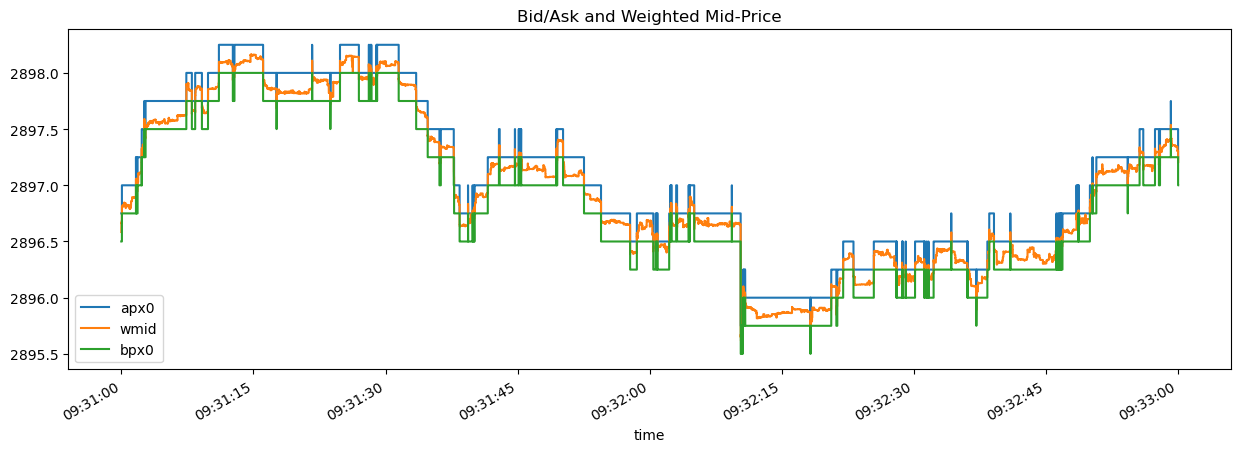

In [16]:
%%py
b.plot(drawstyle='steps-post',title='Bid/Ask and Weighted Mid-Price')


# Book Pressure
- Each level of the book applies a pressure to the mid price
- HFT can add and cancel many orders in the order book with no
  expectation of getting executed
- Confidence in the order book levels should decrease the further
  deeper we go
- What is the likelihood the price will move to a specific level?
- One choice is to make it a function of the stock's volatility

In [17]:
s:h(snapshot;sym;dt+0D16)
t:flip select px:bprice,bsz:bsize,cumbsz:sums bsize,asz:0n,cumasz:0n from s
t,:flip select px:aprice,asz:asize,cumasz:sums asize from s
t:`px xasc 0f^t
.pykx.set[`mid] .pykx.tonp mid:exec .5*bprice[0]+aprice[0] from s
.pykx.set[`std] .pykx.tonp std:mid*.1%sqrt 252*6.5*60
.pykx.set[`t] .pykx.topd 1!t

## Plot of book pressure as a function of price

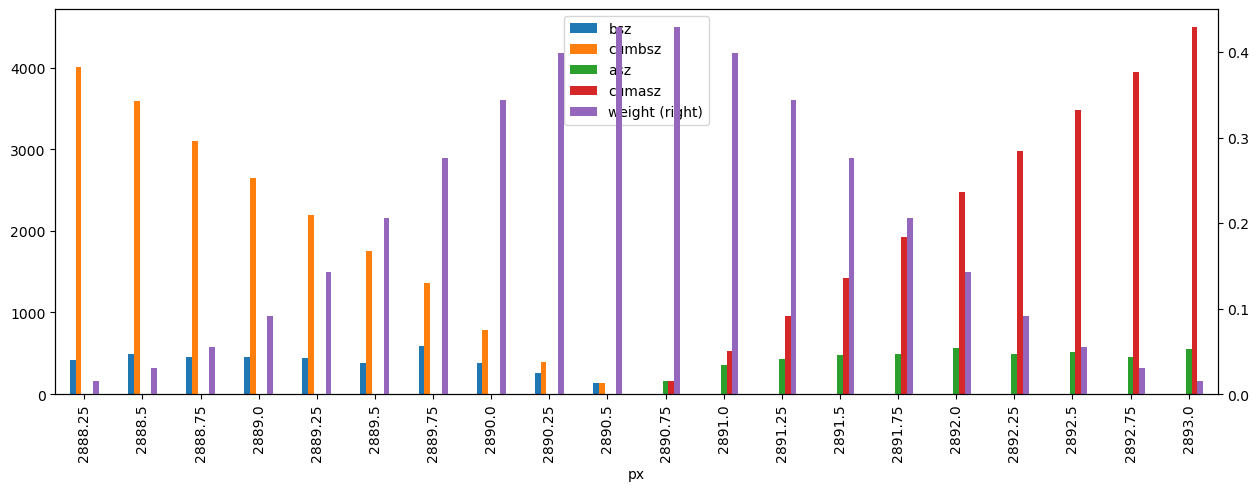

2890.625
2890.581762572733


In [18]:
%%py
t['weight']=sp.stats.norm.pdf(t.index.values,mid,std)
t.plot(secondary_y='weight',kind='bar')
plt.show()
print(mid)
print(mid+np.average(mid-t.index,0,(t.bsz+t.asz)*t.weight))

# Volume-Adjusted Mid-Price
- How can we estimate the pressure of a thin order book
- What about order books that have small order sizes scattered across
  multiple ticks
- Crypto market structure has no practical tick-size, order prices can
  be placed with differences down to the 18 decimal places (for ERC-20
  tokens)
  

## VAMP implementation
- [Payton Marin et al. (2022)][VAMP] suggest deriving mid prices with
  bid and ask prices that are computed by averaging as much of the
  order book as required to fill a volume $v$.
  
$$
P^{\text{vamp}}_v = \frac{P^a + P^b}{2}
$$

where $ P^b = \frac{\sum_i^kP^b\times V^b}{v}$, $ P^a =
\frac{\sum_i^kP^a\times V^a}{v}$ and $k$ is chosen such that required
$v$ can be fully executed.

[VAMP]: https://dx.doi.org/10.2139/ssrn.4351947 "Payton Martin et al. (2022)"

In [19]:
vamp:{[dt;trng;s;v]
 t:select from book where date = dt; / only memory maps data, does not load into ram
 / just select columns we need because further filtering loads data into ram
 t:select time,bsize,bprice,aprice,asize from t where sym=s, time within gtime dt+trng;
 pfv:{[v;V;P]sum[P*deltas v&sums V]%v}; / inner functions can be reused
 t:update pbid:bsize pfv[v]' bprice, pask:asize pfv[v]' aprice from t;
 t:select ltime time,pbid,bid:bprice[;0],ask:aprice[;0],pask from t;
 t:update vamp:.5*pbid+pask from t;
 t}
v:h(vamp;dt;0D 1D;sym;200)

In [20]:
.pykx.set[`vamp] .pykx.topd 1!select time,bid,vamp,ask from v where time within 09:31:00 09:33:00;


## Intraday plot of volume-adjusted mid-price

<Axes: title={'center': 'Bid/Ask and Volume Adjusted Mid-Price'}, xlabel='time'>

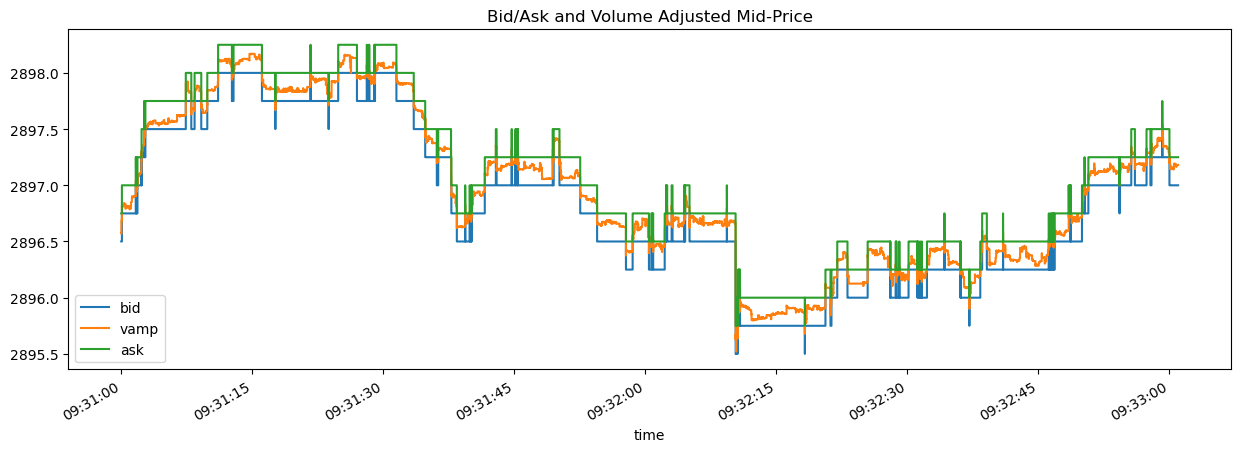

In [21]:
%%py
vamp.plot(drawstyle='steps-post',title='Bid/Ask and Volume Adjusted Mid-Price')


# Volume-Adjusted Spread
- How can we evaluate book quality?
- Is the spread really just the difference between a 1-lot bid and
  ask?
- If we choose a *typical* order notional, we can traverse the order
  book to find an average bid and ask price that would be sufficient
  to fill our order
- Using the same bid and ask prices computed for Volume-Adjusted
  Mid-Price (VAMP), we can compute a Volume-Adjusted Spread


In [22]:
.pykx.set[`vas] .pykx.topd select by 0D00:01 xbar time from select time,pbid-vamp,pask-vamp from v


## Intraday plot of volume-adjusted spread

<Axes: title={'center': 'Volume-Adjusted Spread'}, xlabel='time'>

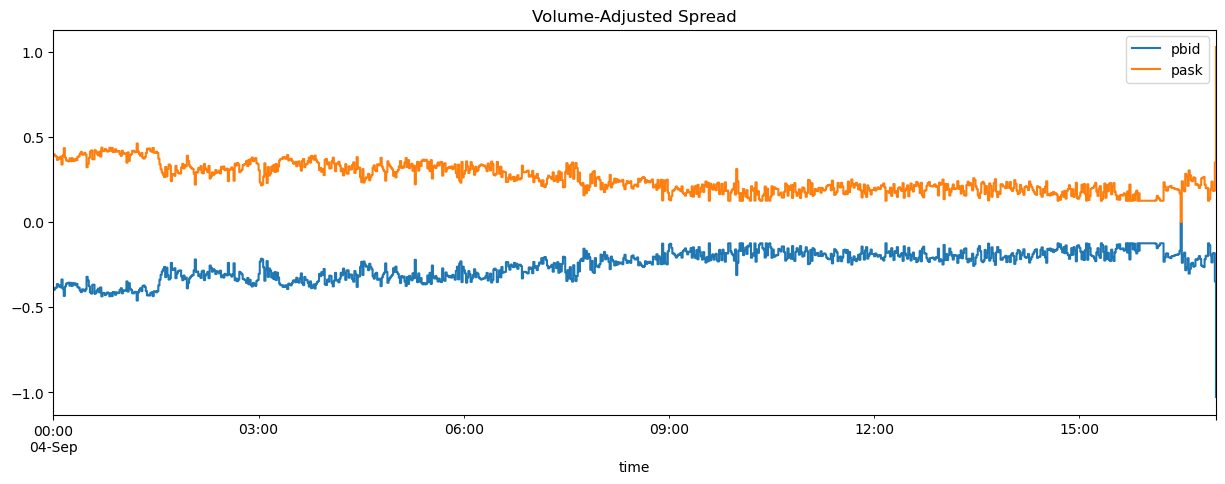

In [23]:
%%py
vas.plot(drawstyle='steps-post',title='Volume-Adjusted Spread')


# Message Rate Variation
- We use a function to aggregate messages rates by parameterizable window
- We define a `plot` function for reuse

In [24]:
events:{[t;drng;trng;bar;win;s]
 e:select ltime time from t where date within drng,sym=s;
 e:select n:count i by time:(bar xbar "n"$time) mod "j"$win from e where time within trng;
 e}

In [25]:
%%py
def plot(df):
 df.index=pd.to_timedelta(df.index)
 df.plot(drawstyle='steps-post')


## Daily Message Rate Variation
- Message rates start high and gradually fall (along with volumes,
  spreads and volatility)
- Messages rates spike at the close

In [ ]:
.pykx.set[`e] .pykx.topd e:h (events;`book;2018.09.01 2018.09.30;09:30 16:00;0D00:01;1D00;sym)
p)plot(e)

## Hourly Message Rate Variation
- Looking more closely, we can see structure within the hour, both at the
  start of the hour as well as at the half-hour mark


In [ ]:
.pykx.set[`e] .pykx.topd e:h (events;`book;2018.09.01 2018.09.30;09:30 16:00;0D00:00:10;0D01;sym)
p)plot(e)

## Minutely Message Rate Variation
- There are spikes at the minute mark too, and it seems there are frequent
  spikes at the second level


In [ ]:
.pykx.set[`e] .pykx.topd e:h (events;`book;2018.09.01 2018.09.30;09:30 16:00;0D00:00:00.1;0D00:01;sym)
p)plot(e)

## Sub-second Message Rate Variation
- How about within each the second?

In [ ]:
.pykx.set[`e] .pykx.topd e:h (events;`book;2018.09.01 2018.09.30;09:30 16:00;0D00:00:00.001;0D00:00:01;sym)
p)plot(e)

# Patterns in Message Rates
- Lets convert time into frequency to look for patterns
- Starting with message counts at the .1 second frequency

In [ ]:
.pykx.set[`e] .pykx.topd e:h (events;`book;2018.09.01 2018.09.30;09:30 16:00;0D00:00:00.1;1D00;sym)
p)plot(e)

## Fast Fourier Transform
- Passing the values to the FFT algorithm returns the frequencies
  hidden within the data
- Note that we only plot the first *half* of the values because the
  FFT of a real-valued signal is [mirrored][MIRROREDFFT]
- We take the _log_ of the amplitude to make the peaks visually
  apparent
- In addition to low frequency peaks (corresponding to minutes, hours,
  etc) we can see distinct peaks at 1, 2, 3, 4, and 5 Hz (1-per
  second, 2-per second, etc)

[MIRROREDFFT]: https://dsp.stackexchange.com/questions/4825/why-is-the-fft-mirrored "Mirrored FFT"


In [ ]:
%%py
y=e['n'].values
N=y.size
T=.001
T=(e.index[1]-e.index[0]).total_seconds()
yf=sp.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/T,N)
plt.plot(xf[:N//2], np.log(np.abs(yf[:N//2]))*1/N)
plt.ylabel("log(amplitude)")
plt.xlabel("frequency [Hz]")


# Message Rate Around Trades
- Do message rates spike before or after trades?
- Does the second hump reflect how long it takes the market to react
  to a trade?
- Window join (`wj1`) and markout creation covered in next class

In [ ]:
trades:{[drng;trng;bar;n;s]
 t:select ltime time from trade where date within drng,sym=s,time within trng;
 b:select ltime time from book where date within drng,sym=s,time within trng;
 b:0!select n:count i by bar xbar time from b; / book events per bar
 t:t cross ([]lag:bar*neg[n]+til 1+2*n); / multiple lags for each trade time
 w:sum[t`time`lag]+/:(0;bar); / 1-bar window for each lag
 t:select avg n by lag from wj1[w;`time;t;(b;(sum;`n))]; / sum book events across trade lags
 t}

In [ ]:
.pykx.set[`df] .pykx.topd h (trades;2018.09.01 2018.09.04;09:30 16:00;0D00:00:00.001;50;sym)
p)plot(df)